In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tqdm import tqdm
import random

# set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

from utils import *
from gen import test, random_search, true_random_search, true_random_nsteps


In [2]:
env = gym.make(
    "MiniHack-ExploreMaze-Hard-Mapped-v0",
    observation_keys=("chars", "pixel"),
    #des_file = "simple_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
env.render()


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---         ----          ---                                                   
|.           .>            .|                                                   
|...... ....... . ..... ....|                                                   
|..   . . . ... . . . .   ..|                                                   
|.. . ... . ... ... . ......|                                                   
|.. .     .  ..     .     ..|                                                   
|........ ..... ... . ... ..|                                                   
|..         ... . . .   . ..|                                                   
|.............. . . ... ...

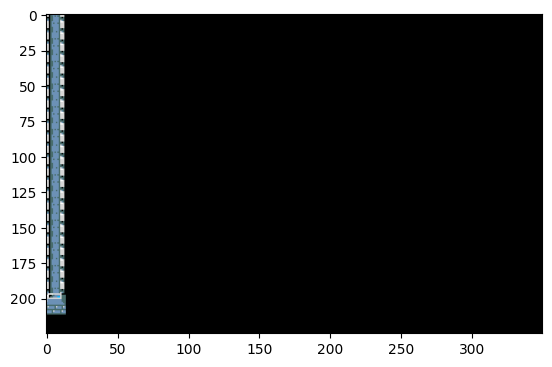

In [3]:
plt.imshow(state['pixel'][75:300, 450:800])

In [4]:
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

In [5]:
a = (0, -1)
b = (0, 1)
c = (1, 0)      
d = (-1, 0)

ACTIONS = [a, b, c, d]

def modify_action(t1, t2):
    """Sum two tuples"""
    return (t1[0] + t2[0], t1[1] + t2[1])

def is_crossoverable(action1, action2):
    # if action 1 and action 2 are oblique, return False
    dx = abs(action1[0] - action2[0])
    dy = abs(action1[1] - action2[1])
    # return false if the two components are changing together and > 1
    if dx > 0 and dy > 0:
        return False
    else:
        return True

def crossover(path1, path2):
    """Crossover two paths"""
    # randomly select a crossover point
    i = np.random.randint(1, min(len(path1), len(path2)))
    while not is_crossoverable(path1[i-1], path2[i]):
        i = np.random.randint(1, min(len(path1), len(path2)))

    # return the two paths joined at the crossover point
    return path1[:i] + path2[i:]
     

def mutate(path, mutation_rate=0.05):
    """Mutate a path"""
    # randomly select n postions to mutate
   
    actions = actions_from_path(path[0], path[1:])
    idxs = random.choices(range(actions)), k=10)
    # randomly select new actions for each position and replace
    # TODO?  implement controls on move validity
    for idx in idxs:
        action = random.choice([0,1,2,3])
        actions[idx] = action
    path = path_from_actions(path[0], actions)
    return path

In [8]:


MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 50

best_scores =[]
best_paths = []

state = env.reset()
env = gym.make(
    "MiniHack-ExploreMaze-Hard-Mapped-v0",
    observation_keys=("chars", "pixel"),
    #des_file = "simple_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
env.render()

# this is manhattan distance from the last element of the path to the target
fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [true_random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]
best_fitness = np.inf

# create a list of tuples (individual, fitness)
print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS), postfix=f'best score: {best_fitness:.2f}'):
    generation_scores = []
    
    fitnesses = [fitness_function(individual) for individual in individuals]
    generation_scores.append(min(fitnesses))

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    
    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.
    child1, child2 = population[0], population[1]
    offspring = [crossover(child1[0], child2[0]) for _ in range(MAX_INDIVIDUALS)]
    offspring = [mutate(child) for child in offspring]
    individuals = offspring
    best_fitness = population[0][1]
    best_scores.append(population[0][1])    
    best_paths.append(population[0][0])
    print(f"Generation {generation}: best score {best_fitness:.2f}")
    


Hello Agent, welcome to NetHack!  You are a chaotic male human Rogue.           
                                                                                
                                                                                
                                                                                
---         ----          ---                                                   
|.           ..            .|                                                   
|...... ....... ......... ..|                                                   
|..   .   .  ..     . . . ..|                                                   
|.... ... ..... ... . . ....|                                                   
|@ ..   .   ..> . . . .   ..|                                                   
|...... ... ... . . . . ....|                                                   
|..   .   . ..... .   . .  .|                                                   
|.... ... . ... ... ... . .

  0%|          | 0/1000 [00:00<?, ?it/s, best score: inf]

RuntimeError: Called step on finished NetHack

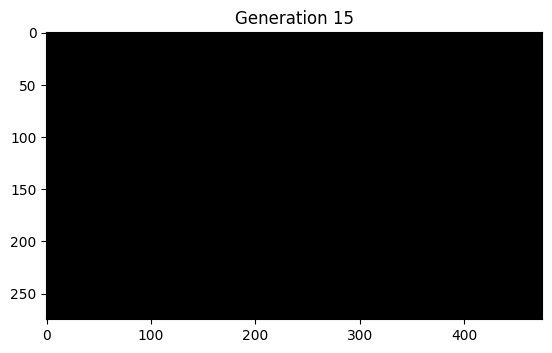

In [13]:
image = plt.imshow(game[25:300, :475])
for generation, path in enumerate(best_paths):
    plt.title(f"Generation {generation}")
    start = path[0]
    path = path[1:]
    actions = actions_from_path(start, path)
    
    for action in actions:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(s['pixel'][25:300, :475])
    